In [1]:
import ast
import matplotlib.pyplot as plt
from minisom import MiniSom
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             adjusted_mutual_info_score, calinski_harabasz_score)

In [2]:
rng = np.random.default_rng()

In [3]:
genres = ['rock', 'classical', 'latin', 'filmi']
tracks = pd.read_csv('../data/tracks_with_genres.csv')
tracks['genres'] = tracks['genres'].apply(ast.literal_eval)
tracks = tracks.explode('genres')
tracks.rename(columns={'genres': 'genre'}, inplace=True)
tracks_subset = tracks[tracks['genre'].isin(genres)]

In [4]:
tracks_genres = tracks_subset['genre'].astype('category')
labels_integers = tracks_genres.cat.codes

## Data
A subset of the data has been used for clustering in this notebook.
The distribution of the data between genres can be seen in the following plot.

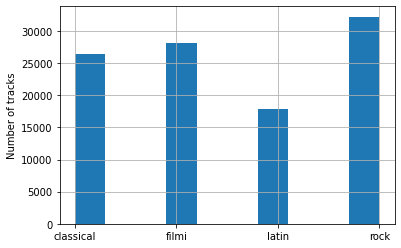

In total, there are 104438 tracks in the dataset used.


In [5]:
tracks_subset['genre'].hist()
plt.ylabel('Number of tracks')
plt.show()
print(f'In total, there are {tracks_subset.shape[0]} tracks in the dataset used.')


Convert the pandas dataframe to a matrix of numerical values, normalize the values column wise and shuffle the rows.

In [6]:
features = ['acousticness', 'instrumentalness', 'loudness', 'energy', 'danceability', 'valence']
tracks_values = tracks_subset[features].values
tracks_values = (tracks_values - tracks_values.mean(axis=0))/tracks_values.std(axis=0)
rng.shuffle(tracks_values, axis=0)

## Clustering

In [7]:
som_clusters = (44, 44)
som = MiniSom(som_clusters[0], som_clusters[1], tracks_values.shape[1],
              sigma=2, learning_rate=0.01)
som.train_batch(tracks_values, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.5230085647637525


In [8]:
neuron_activations = som.activation_response(tracks_values)

In [9]:
dbscan = DBSCAN(eps=0.5, n_jobs=-1, min_samples=5)
labels = dbscan.fit_predict(
    som._weights.reshape(som._weights.shape[0]*som._weights.shape[1],
                         som._weights.shape[2]))
print(np.unique(labels))

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)

[-1  0  1  2  3  4  5  6  7  8]
9


## Visualize
First we visualize a heat map of the SOM neurons.

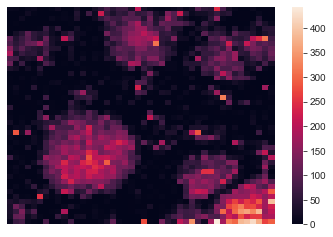

In [10]:
sns.set_style('white')
heatmap = sns.heatmap(neuron_activations)
plt.axis('off')
plt.show()
heatmap.get_figure().savefig('../figures/neurons_heatmap.png')

Then the distance map.

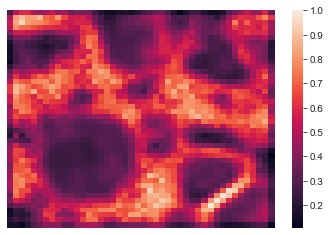

In [11]:
sns.set_style('white')
heatmap = sns.heatmap(som.distance_map())
plt.axis('off')
plt.show()
heatmap.get_figure().savefig('../figures/neurons_heatmap.png')


Finally, the weights of one of the features as a demo.

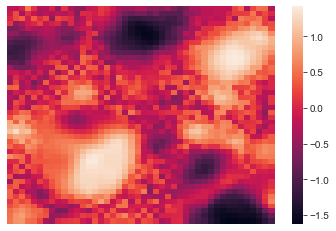

In [12]:
# Feature importance
sns.set_style('white')
heatmap = sns.heatmap(som._weights[:, :, 5])
plt.axis('off')
plt.show()